Evaluating with 5% anomalies
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Unsupervised Models Results for 5% Anomalies:
Isolation Forest: {'Accuracy': 0.946, 'Precision': 0.45652173913043476, 'Recall': 0.9130434782608695, 'F1 Score': 0.6086956521739131, 'AUC-ROC': np.float64(0.9303162883966821)}
One-Class SVM: {'Accuracy': 0.9446666666666667, 'Precision': 0.4527027027027027, 'Recall': 0.9710144927536232, 'F1 Score': 0.6175115207373272, 'AUC-ROC': np.float64(0.9572053595843587)}
Local Outlier Factor: {'Accuracy': 0.9886666666666667, 'Precision': 0.8170731707317073, 'Recall': 0.9710144927536232, 'F1 Score': 0.8874172185430463, 'AUC-ROC': np.float64(0.9802661562300611)}
Autoencoder: {'Accuracy': 0.98, 'Precision': 0.76, 'Recall': 0.8260869565217391, 'F1 Score': 0.7916666666666666, 'AUC-ROC': np.float64(0.906754170084769)}
Evaluating with 10% anomalies
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Unsupervised Models Results for 10% Anomalies:
Isolation Forest: {'Accuracy': 0.942, 'Precision': 0.6590

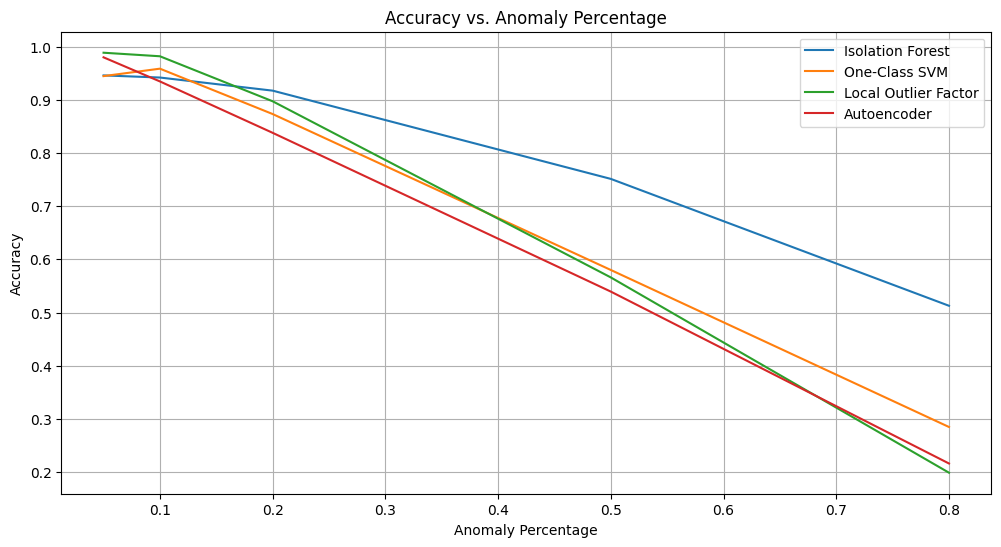

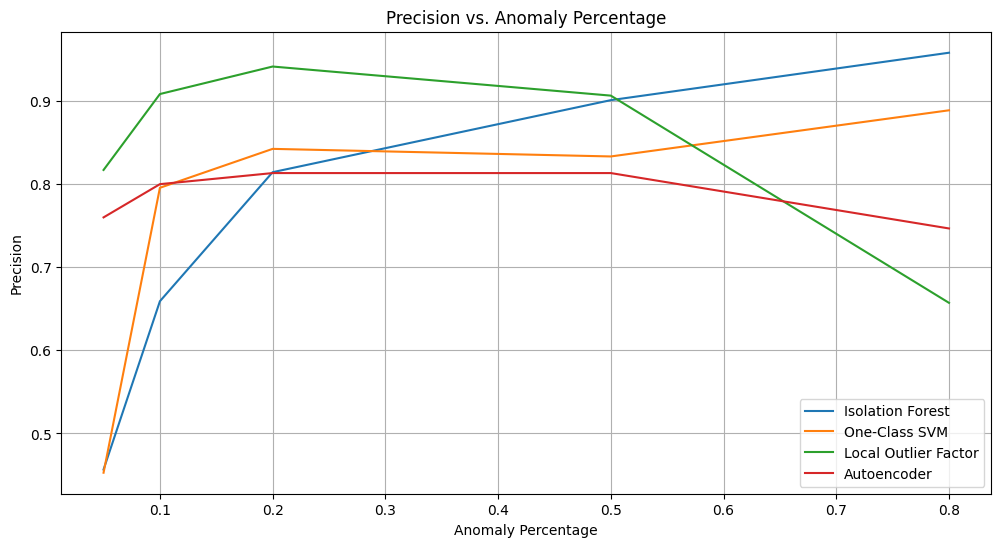

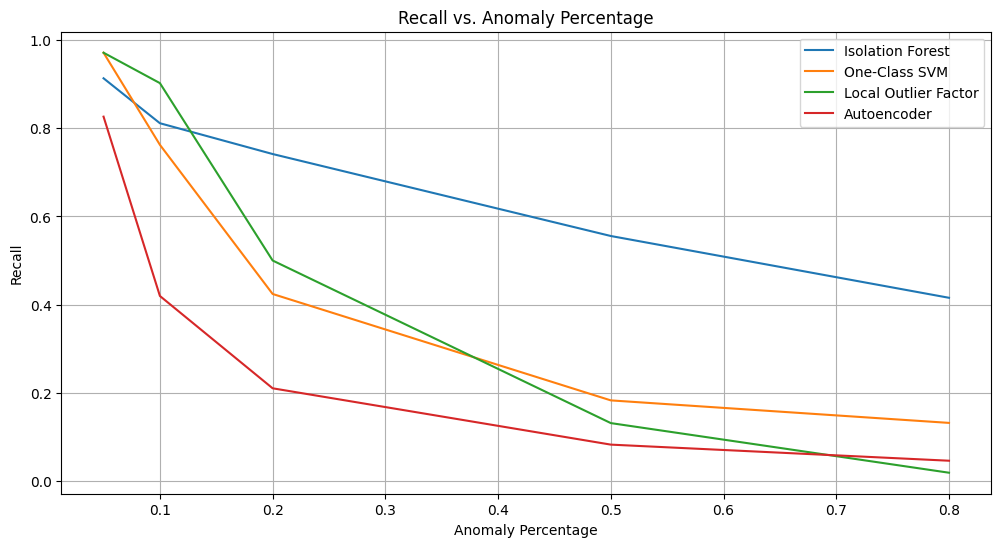

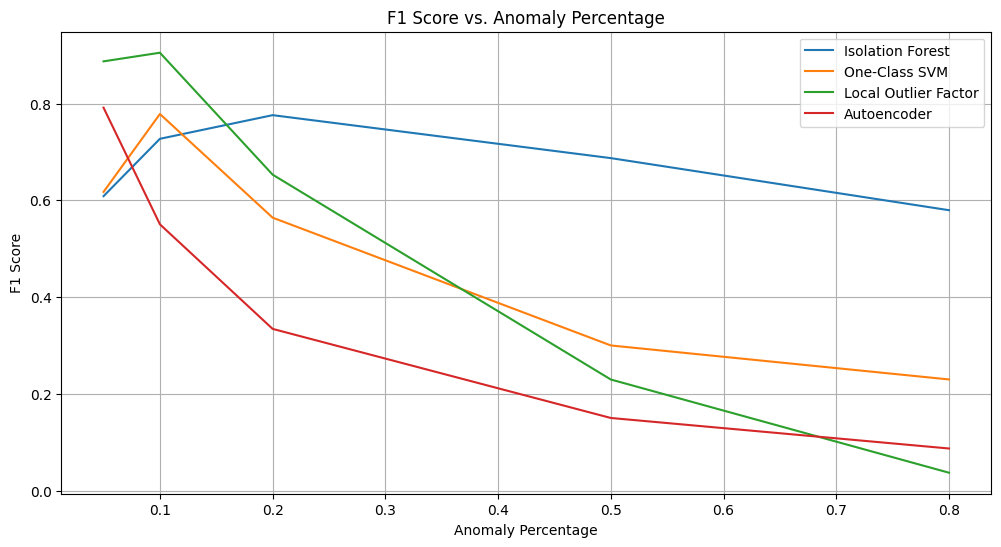

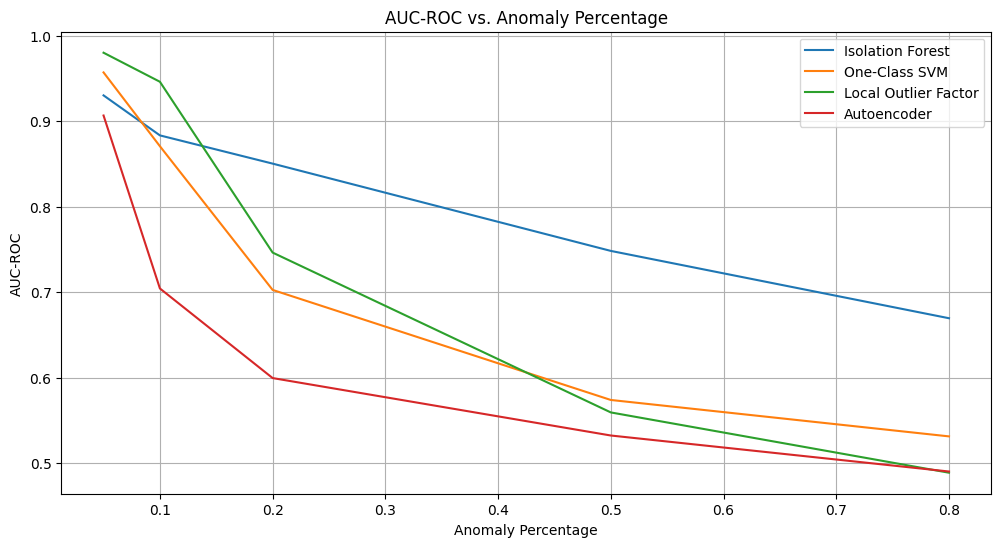

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Define weights for each metric
WEIGHT_COMPLETION_RATE = 0.30
WEIGHT_FEEDBACK_SCORE = 0.30
WEIGHT_DISPUTE_RESOLUTION = 0.20
WEIGHT_COMPLAINT_RATIO = 0.20

# Define thresholds for trust classification
THRESHOLD_HIGH = 0.75
THRESHOLD_MEDIUM = 0.50

# Normalize function
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

# Function to calculate metrics and trust score for a participant
def calculate_metrics(participant_data):
    total_transactions = participant_data['total_transactions']
    successful_transactions = participant_data['successful_transactions']
    feedback_scores = participant_data['feedback_scores']
    resolved_disputes = participant_data['resolved_disputes']
    total_disputes = participant_data['total_disputes']
    complaints = participant_data['complaints']

    completion_rate = successful_transactions / total_transactions if total_transactions > 0 else 0
    average_feedback = sum(feedback_scores) / len(feedback_scores) if len(feedback_scores) > 0 else 0
    dispute_resolution_success = resolved_disputes / total_disputes if total_disputes > 0 else 0
    complaint_ratio = complaints / total_transactions if total_transactions > 0 else 0

    norm_completion_rate = normalize(completion_rate, 0, 1)
    norm_feedback_score = normalize(average_feedback, 0, 5)
    norm_dispute_resolution_success = normalize(dispute_resolution_success, 0, 1)
    norm_complaint_ratio = 1 - normalize(complaint_ratio, 0, 1)

    trust_score = (
        (norm_completion_rate * WEIGHT_COMPLETION_RATE) +
        (norm_feedback_score * WEIGHT_FEEDBACK_SCORE) +
        (norm_dispute_resolution_success * WEIGHT_DISPUTE_RESOLUTION) +
        (norm_complaint_ratio * WEIGHT_COMPLAINT_RATIO)
    )

    if trust_score >= THRESHOLD_HIGH:
        trust_class = 'High Trust'
    elif trust_score >= THRESHOLD_MEDIUM:
        trust_class = 'Medium Trust'
    else:
        trust_class = 'Low Trust'

    return {
        'completion_rate': completion_rate,
        'average_feedback': average_feedback,
        'dispute_resolution_success': dispute_resolution_success,
        'complaint_ratio': complaint_ratio,
        'trust_score': trust_score,
        'trust_class': trust_class
    }

def generate_synthetic_data(n_samples=5000, anomaly_percentage=0.1):
    np.random.seed(42)
    data = []
    for _ in range(n_samples):
        total_transactions = np.random.randint(1, 100)
        successful_transactions = np.random.randint(0, total_transactions)
        feedback_scores = np.random.rand(np.random.randint(1, 10)).tolist()
        resolved_disputes = np.random.randint(0, total_transactions)
        total_disputes = np.random.randint(1, total_transactions + 1)
        complaints = np.random.randint(0, total_transactions)

        participant_data = {
            'total_transactions': total_transactions,
            'successful_transactions': successful_transactions,
            'feedback_scores': feedback_scores,
            'resolved_disputes': resolved_disputes,
            'total_disputes': total_disputes,
            'complaints': complaints
        }

        metrics = calculate_metrics(participant_data)
        data.append([
            metrics['completion_rate'],
            metrics['average_feedback'],
            metrics['dispute_resolution_success'],
            metrics['complaint_ratio'],
            metrics['trust_score']
        ])
    
    data = np.array(data)
    labels = np.zeros(n_samples)
    n_anomalies = int(n_samples * anomaly_percentage)
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    labels[anomaly_indices] = 1
    data[anomaly_indices, :] = np.random.uniform(low=-1, high=2, size=(n_anomalies, data.shape[1]))
    
    return data, labels

def build_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(14, input_dim=input_dim, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def evaluate_unsupervised_models(X_train, y_train, X_test, y_test):
    results = {}

    # Train Isolation Forest
    iforest = IsolationForest(contamination='auto', random_state=42)
    y_pred_if = iforest.fit_predict(X_test)
    y_pred_if = np.where(y_pred_if == -1, 1, 0)
    results['Isolation Forest'] = {
        'Accuracy': accuracy_score(y_test, y_pred_if),
        'Precision': precision_score(y_test, y_pred_if),
        'Recall': recall_score(y_test, y_pred_if),
        'F1 Score': f1_score(y_test, y_pred_if),
        'AUC-ROC': roc_auc_score(y_test, y_pred_if)
    }

    # Train One-Class SVM
    oc_svm = OneClassSVM(gamma='auto', nu=0.1)
    oc_svm.fit(X_train)
    y_pred_oc_svm = oc_svm.predict(X_test)
    y_pred_oc_svm = np.where(y_pred_oc_svm == -1, 1, 0)
    results['One-Class SVM'] = {
        'Accuracy': accuracy_score(y_test, y_pred_oc_svm),
        'Precision': precision_score(y_test, y_pred_oc_svm),
        'Recall': recall_score(y_test, y_pred_oc_svm),
        'F1 Score': f1_score(y_test, y_pred_oc_svm),
        'AUC-ROC': roc_auc_score(y_test, y_pred_oc_svm)
    }

    # Train Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
    y_pred_lof = lof.fit_predict(X_test)
    y_pred_lof = np.where(y_pred_lof == -1, 1, 0)
    results['Local Outlier Factor'] = {
        'Accuracy': accuracy_score(y_test, y_pred_lof),
        'Precision': precision_score(y_test, y_pred_lof),
        'Recall': recall_score(y_test, y_pred_lof),
        'F1 Score': f1_score(y_test, y_pred_lof),
        'AUC-ROC': roc_auc_score(y_test, y_pred_lof)
    }

    # Train Autoencoder
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)
    X_test_reconstructed = autoencoder.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    y_pred_autoencoder = np.where(reconstruction_error > threshold, 1, 0)
    results['Autoencoder'] = {
        'Accuracy': accuracy_score(y_test, y_pred_autoencoder),
        'Precision': precision_score(y_test, y_pred_autoencoder),
        'Recall': recall_score(y_test, y_pred_autoencoder),
        'F1 Score': f1_score(y_test, y_pred_autoencoder),
        'AUC-ROC': roc_auc_score(y_test, y_pred_autoencoder)
    }

    return results

# Main execution
anomaly_percentages = [0.05, 0.10, 0.20, 0.50, 0.80]
results = {}

for anomaly_percentage in anomaly_percentages:
    print(f"Evaluating with {int(anomaly_percentage * 100)}% anomalies")
    X, y = generate_synthetic_data(anomaly_percentage=anomaly_percentage)
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Save the generated data to CSV files
    train_df = pd.DataFrame(X_train, columns=['completion_rate', 'average_feedback', 'dispute_resolution_success', 'complaint_ratio', 'trust_score'])
    train_df['label'] = y_train
    train_df.to_csv(f'train_data_{int(anomaly_percentage * 100)}.csv', index=False)

    test_df = pd.DataFrame(X_test, columns=['completion_rate', 'average_feedback', 'dispute_resolution_success', 'complaint_ratio', 'trust_score'])
    test_df['label'] = y_test
    test_df.to_csv(f'test_data_{int(anomaly_percentage * 100)}.csv', index=False)
    
    # Evaluate unsupervised models
    unsupervised_results = evaluate_unsupervised_models(X_train, y_train, X_test, y_test)
    results[anomaly_percentage] = unsupervised_results
    print(f"Unsupervised Models Results for {int(anomaly_percentage * 100)}% Anomalies:")
    for model, metrics in unsupervised_results.items():
        print(f"{model}: {metrics}")

# Optionally, plot feature importances
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

# Plot evaluation metrics for each anomaly percentage
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for model in ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor', 'Autoencoder']:
        scores = [results[anomaly_percentage][model][metric] for anomaly_percentage in anomaly_percentages]
        plt.plot(anomaly_percentages, scores, label=model)
    plt.xlabel('Anomaly Percentage')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Anomaly Percentage')
    plt.legend()
    plt.grid(True)
    plt.show()


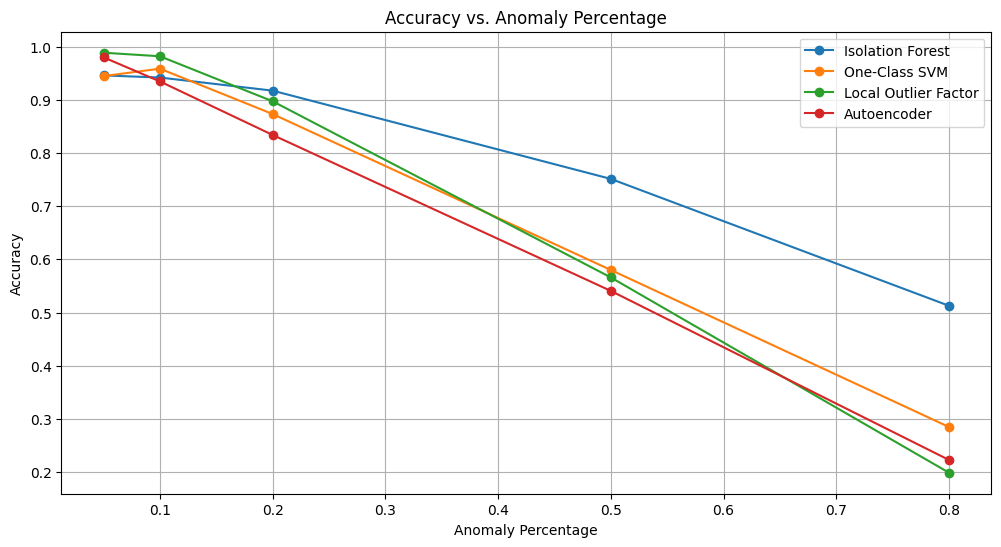

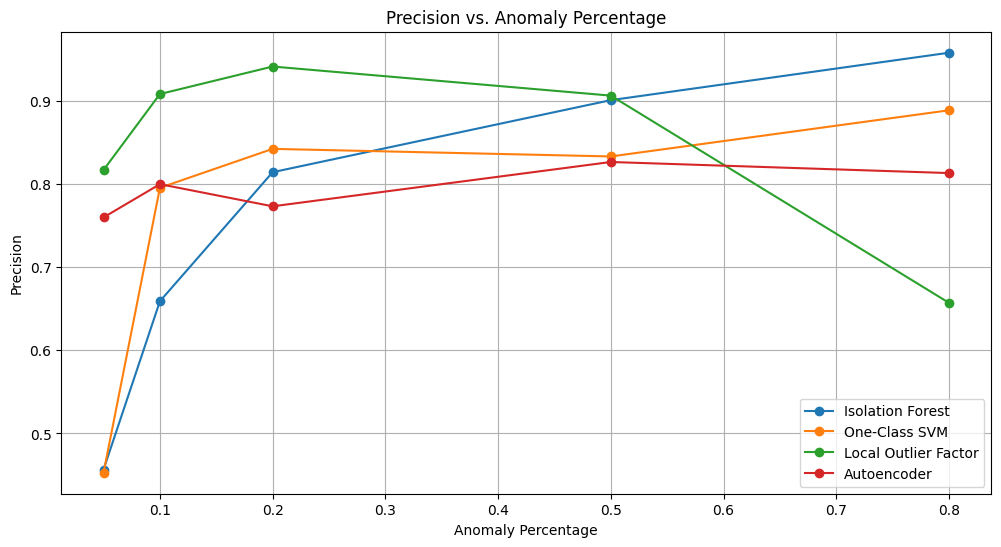

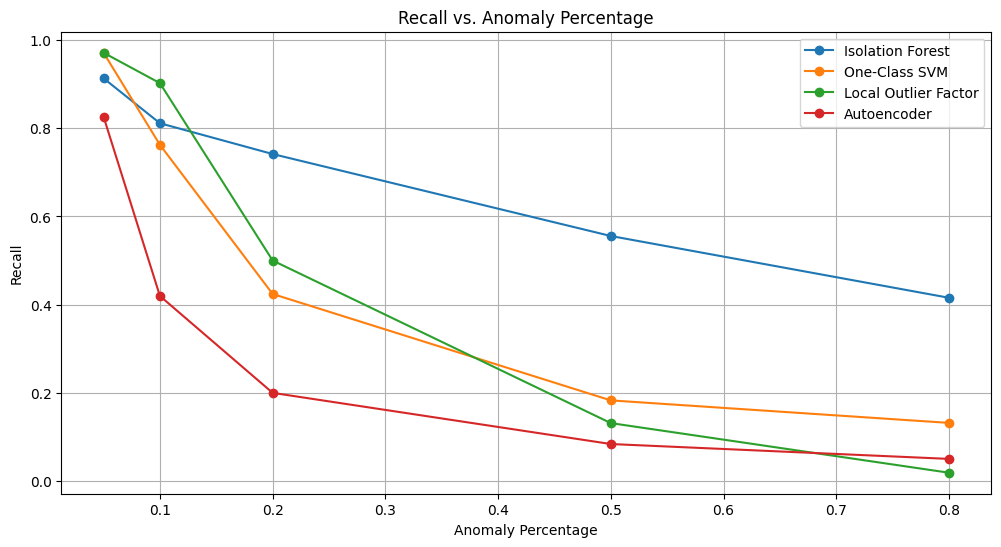

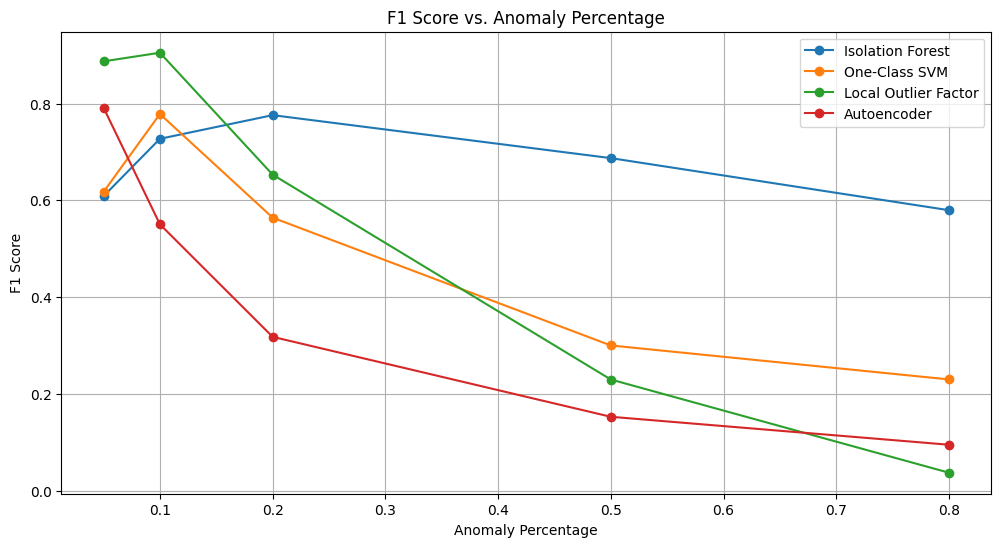

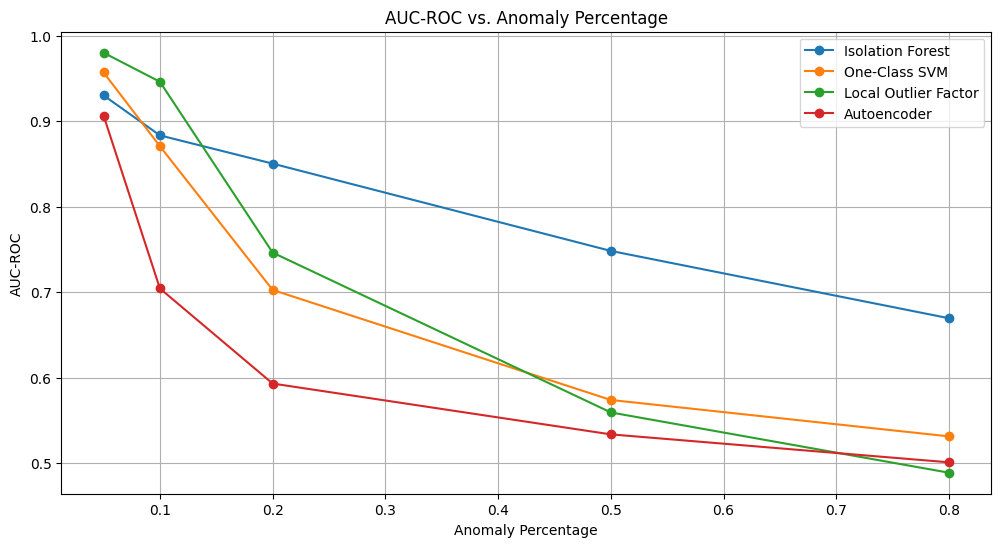

In [5]:
import matplotlib.pyplot as plt

# Define the results from the simulation
results = {
    0.05: {
        'Isolation Forest': {'Accuracy': 0.946, 'Precision': 0.45652173913043476, 'Recall': 0.9130434782608695, 'F1 Score': 0.608695652173913, 'AUC-ROC': 0.9303162883966821},
        'One-Class SVM': {'Accuracy': 0.9446666666666667, 'Precision': 0.4527027027027027, 'Recall': 0.9710144927536232, 'F1 Score': 0.6175115207373271, 'AUC-ROC': 0.9572053595843587},
        'Local Outlier Factor': {'Accuracy': 0.9886666666666667, 'Precision': 0.8170731707317073, 'Recall': 0.9710144927536232, 'F1 Score': 0.8874172185430462, 'AUC-ROC': 0.9802661562300611},
        'Autoencoder': {'Accuracy': 0.98, 'Precision': 0.76, 'Recall': 0.8260869565217391, 'F1 Score': 0.7916666666666667, 'AUC-ROC': 0.906754170084769}
    },
    0.10: {
        'Isolation Forest': {'Accuracy': 0.942, 'Precision': 0.6590909090909091, 'Recall': 0.8111888111888111, 'F1 Score': 0.7272727272727272, 'AUC-ROC': 0.8834868153217452},
        'One-Class SVM': {'Accuracy': 0.9586666666666667, 'Precision': 0.7956204379562044, 'Recall': 0.7622377622377622, 'F1 Score': 0.7785714285714285, 'AUC-ROC': 0.8708020056583062},
        'Local Outlier Factor': {'Accuracy': 0.982, 'Precision': 0.9084507042253521, 'Recall': 0.9020979020979021, 'F1 Score': 0.9052631578947369, 'AUC-ROC': 0.9462589731565414},
        'Autoencoder': {'Accuracy': 0.9346666666666666, 'Precision': 0.8, 'Recall': 0.4195804195804196, 'F1 Score': 0.5504587155963303, 'AUC-ROC': 0.7042633122220449}
    },
    0.20: {
        'Isolation Forest': {'Accuracy': 0.9173333333333333, 'Precision': 0.8143939393939394, 'Recall': 0.7413793103448276, 'F1 Score': 0.776173285198556, 'AUC-ROC': 0.8504417212881162},
        'One-Class SVM': {'Accuracy': 0.8733333333333333, 'Precision': 0.8424657534246576, 'Recall': 0.4241379310344828, 'F1 Score': 0.5642201834862386, 'AUC-ROC': 0.7025648332858365},
        'Local Outlier Factor': {'Accuracy': 0.8973333333333333, 'Precision': 0.9415584415584416, 'Recall': 0.5, 'F1 Score': 0.6531531531531533, 'AUC-ROC': 0.7462809917355372},
        'Autoencoder': {'Accuracy': 0.834, 'Precision': 0.7733333333333333, 'Recall': 0.2, 'F1 Score': 0.3178082191780822, 'AUC-ROC': 0.5929752066115702}
    },
    0.50: {
        'Isolation Forest': {'Accuracy': 0.7513333333333333, 'Precision': 0.9010989010989011, 'Recall': 0.5555555555555556, 'F1 Score': 0.6873428331936294, 'AUC-ROC': 0.7482502187226597},
        'One-Class SVM': {'Accuracy': 0.58, 'Precision': 0.8333333333333334, 'Recall': 0.18292682926829268, 'F1 Score': 0.3, 'AUC-ROC': 0.5737468792010755},
        'Local Outlier Factor': {'Accuracy': 0.566, 'Precision': 0.9065420560747663, 'Recall': 0.13143631436314362, 'F1 Score': 0.22958579881656802, 'AUC-ROC': 0.5591564773915455},
        'Autoencoder': {'Accuracy': 0.5406666666666666, 'Precision': 0.8266666666666667, 'Recall': 0.08401084010840108, 'F1 Score': 0.15252152521525214, 'AUC-ROC': 0.5334752363271663}
    },
    0.80: {
        'Isolation Forest': {'Accuracy': 0.5126666666666667, 'Precision': 0.9581749049429658, 'Recall': 0.4154987633965375, 'F1 Score': 0.5796434732604946, 'AUC-ROC': 0.6694218555658645},
        'One-Class SVM': {'Accuracy': 0.2846666666666667, 'Precision': 0.8888888888888888, 'Recall': 0.13190436933223412, 'F1 Score': 0.22972002871500358, 'AUC-ROC': 0.5311089790912041},
        'Local Outlier Factor': {'Accuracy': 0.19866666666666666, 'Precision': 0.6571428571428571, 'Recall': 0.018961253091508656, 'F1 Score': 0.03685897435897436, 'AUC-ROC': 0.4885747032008066},
        'Autoencoder': {'Accuracy': 0.22266666666666668, 'Precision': 0.8133333333333334, 'Recall': 0.05028854080791426, 'F1 Score': 0.09472049689440995, 'AUC-ROC': 0.5007540265015181}
    }
}

anomaly_percentages = [0.05, 0.10, 0.20, 0.50, 0.80]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']

# Plot evaluation metrics for each anomaly percentage
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for model in ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor', 'Autoencoder']:
        scores = [results[anomaly_percentage][model][metric] for anomaly_percentage in anomaly_percentages]
        plt.plot(anomaly_percentages, scores, label=model, marker='o')
    plt.xlabel('Anomaly Percentage')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Anomaly Percentage')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

# Create synthetic trust score data
def create_trust_score_data(n_samples=1000, malicious_ratio=0.2):
    np.random.seed(42)
    n_malicious = int(n_samples * malicious_ratio)
    n_honest = n_samples - n_malicious

    honest_data = np.random.normal(loc=0.8, scale=0.05, size=(n_honest, 4))
    malicious_data = np.random.normal(loc=0.4, scale=0.1, size=(n_malicious, 4))

    data = np.vstack([honest_data, malicious_data])
    labels = np.array([0] * n_honest + [1] * n_malicious)

    return data, labels

# Build a simple autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

# Evaluate models with hyperparameter tuning
def evaluate_unsupervised_models(X_train, y_train, X_test, y_test):
    results = {}

    # --- Isolation Forest Hyperparameter Tuning ---
    best_if_score = 0
    for n_estimators in [100, 200]:
        for contamination in [0.05, 0.1, 0.2]:
            iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
            y_pred = iforest.fit_predict(X_test)
            y_pred = np.where(y_pred == -1, 1, 0)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_if_score:
                best_if_score = f1
                results['Isolation Forest'] = {
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'F1 Score': f1,
                    'AUC-ROC': roc_auc_score(y_test, y_pred),
                    'Best Params': {'n_estimators': n_estimators, 'contamination': contamination}
                }

    # --- Local Outlier Factor Hyperparameter Tuning ---
    best_lof_score = 0
    for n_neighbors in [10, 20, 30, 50]:
        for contamination in [0.05, 0.1, 0.2]:
            lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
            y_pred = lof.fit_predict(X_test)
            y_pred = np.where(y_pred == -1, 1, 0)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_lof_score:
                best_lof_score = f1
                results['Local Outlier Factor'] = {
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'F1 Score': f1,
                    'AUC-ROC': roc_auc_score(y_test, y_pred),
                    'Best Params': {'n_neighbors': n_neighbors, 'contamination': contamination}
                }

    # --- One-Class SVM Hyperparameter Tuning ---
    best_ocsvm_score = 0
    for nu in [0.01, 0.05, 0.1, 0.2]:
        for gamma in ['scale', 'auto']:
            oc_svm = OneClassSVM(nu=nu, gamma=gamma)
            oc_svm.fit(X_train)
            y_pred = oc_svm.predict(X_test)
            y_pred = np.where(y_pred == -1, 1, 0)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_ocsvm_score:
                best_ocsvm_score = f1
                results['One-Class SVM'] = {
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'F1 Score': f1,
                    'AUC-ROC': roc_auc_score(y_test, y_pred),
                    'Best Params': {'nu': nu, 'gamma': gamma}
                }

    # --- Autoencoder (no tuning) ---
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)
    X_test_reconstructed = autoencoder.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    y_pred = np.where(reconstruction_error > threshold, 1, 0)
    results['Autoencoder'] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred),
        'Threshold': threshold
    }

    return results

# Main
if __name__ == "__main__":
    X, y = create_trust_score_data(n_samples=1000, malicious_ratio=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    results = evaluate_unsupervised_models(X_train, y_train, X_test, y_test)

    for model, metrics in results.items():
        print(f"\n{model} Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Isolation Forest Performance:
Accuracy: 0.9533333333333334
Precision: 0.9166666666666666
Recall: 0.859375
F1 Score: 0.8870967741935484
AUC-ROC: 0.919094279661017
Best Params: {'n_estimators': 100, 'contamination': 0.2}

Local Outlier Factor Performance:
Accuracy: 0.7
Precision: 0.2833333333333333
Recall: 0.265625
F1 Score: 0.27419354838709675
AUC-ROC: 0.5417108050847458
Best Params: {'n_neighbors': 10, 'contamination': 0.2}

One-Class SVM Performance:
Accuracy: 0.8266666666666667
Precision: 0.6
Recall: 0.5625
F1 Score: 0.5806451612903226
AUC-ROC: 0.7304025423728814
Best Params: {'nu': 0.2, 'gamma': 'scale'}

Autoencoder Performance:
Accuracy: 0.8366666666666667
Precision: 1.0
Recall: 0.234375
F1 Score: 0.379746835443038
AUC-ROC: 0.6171875
Threshold: 0.35493559569205585


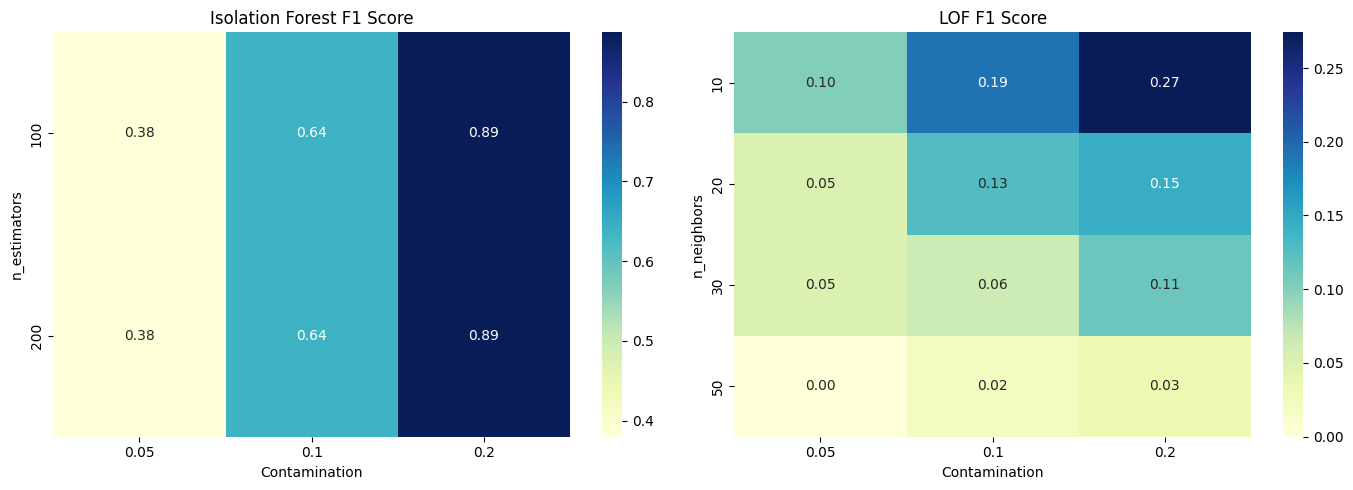

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

# Store all combinations for plotting
if_scores = []
lof_scores = []

# For Isolation Forest
for n_estimators in [100, 200]:
    for contamination in [0.05, 0.1, 0.2]:
        iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
        y_pred = iforest.fit_predict(X_test)
        y_pred = np.where(y_pred == -1, 1, 0)
        f1 = f1_score(y_test, y_pred)
        if_scores.append({'n_estimators': n_estimators, 'contamination': contamination, 'f1_score': f1})

# For LOF
for n_neighbors in [10, 20, 30, 50]:
    for contamination in [0.05, 0.1, 0.2]:
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        y_pred = lof.fit_predict(X_test)
        y_pred = np.where(y_pred == -1, 1, 0)
        f1 = f1_score(y_test, y_pred)
        lof_scores.append({'n_neighbors': n_neighbors, 'contamination': contamination, 'f1_score': f1})

# Convert to DataFrame
df_if = pd.DataFrame(if_scores)
df_lof = pd.DataFrame(lof_scores)

# Pivot for heatmap
pivot_if = df_if.pivot(index='n_estimators', columns='contamination', values='f1_score')
pivot_lof = df_lof.pivot(index='n_neighbors', columns='contamination', values='f1_score')

# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(pivot_if, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Isolation Forest F1 Score")
plt.xlabel("Contamination")
plt.ylabel("n_estimators")

plt.subplot(1, 2, 2)
sns.heatmap(pivot_lof, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("LOF F1 Score")
plt.xlabel("Contamination")
plt.ylabel("n_neighbors")

plt.tight_layout()
plt.show()


Best IF params: {'n_estimators': 100, 'max_samples': 0.5, 'contamination': 0.1}
Best LOF params: {'n_neighbors': 30, 'contamination': 0.1}


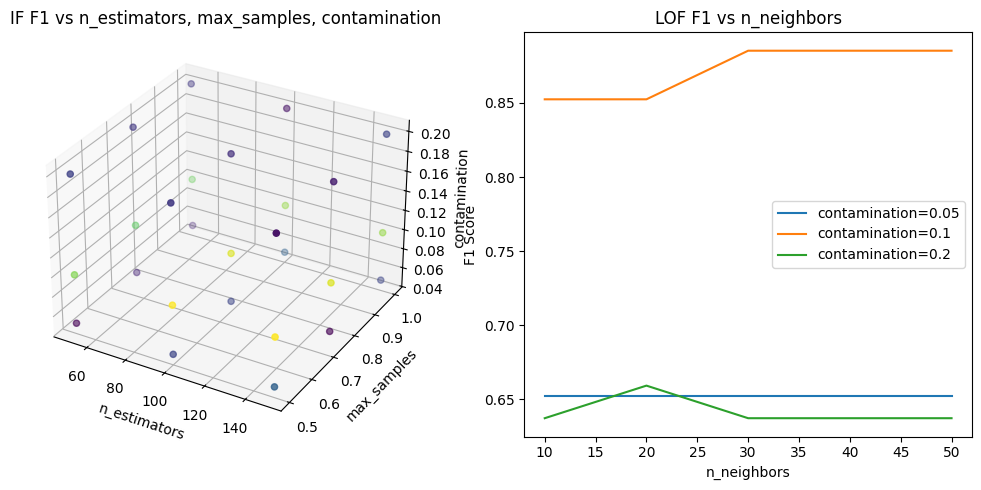

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic data
def generate_data(n_samples=1000, anomaly_percentage=0.1):
    X = np.random.normal(0, 1, size=(n_samples, 5))
    y = np.zeros(n_samples)
    n_anomalies = int(n_samples * anomaly_percentage)
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    X[anomaly_indices] = np.random.uniform(low=-4, high=4, size=(n_anomalies, 5))
    y[anomaly_indices] = 1
    return X, y

# Tuning and plotting function
def tune_and_plot_models(X_train, X_test, y_test):
    # ==== Isolation Forest Tuning ====
    best_if_score = 0
    best_if_params = {}
    if_scores = []

    n_estimators_range = [50, 100, 150]
    max_samples_range = [0.5, 0.75, 1.0]
    contamination_range = [0.05, 0.1, 0.2]

    for n in n_estimators_range:
        for s in max_samples_range:
            for c in contamination_range:
                model = IsolationForest(n_estimators=n, max_samples=s, contamination=c, random_state=42)
                model.fit(X_train)
                preds = model.predict(X_test)
                preds = np.where(preds == -1, 1, 0)
                f1 = f1_score(y_test, preds)
                if_scores.append((n, s, c, f1))
                if f1 > best_if_score:
                    best_if_score = f1
                    best_if_params = {'n_estimators': n, 'max_samples': s, 'contamination': c}

    # ==== LOF Tuning ====
    best_lof_score = 0
    best_lof_params = {}
    lof_scores = []

    n_neighbors_range = [10, 20, 30, 50]
    contamination_range = [0.05, 0.1, 0.2]

    for k in n_neighbors_range:
        for c in contamination_range:
            model = LocalOutlierFactor(n_neighbors=k, contamination=c)
            preds = model.fit_predict(X_test)
            preds = np.where(preds == -1, 1, 0)
            f1 = f1_score(y_test, preds)
            lof_scores.append((k, c, f1))
            if f1 > best_lof_score:
                best_lof_score = f1
                best_lof_params = {'n_neighbors': k, 'contamination': c}

    print("Best IF params:", best_if_params)
    print("Best LOF params:", best_lof_params)

    # ==== Plotting ====
    # Plot IF
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    xs = [x[0] for x in if_scores]
    ys = [x[1] for x in if_scores]
    zs = [x[2] for x in if_scores]
    fs = [x[3] for x in if_scores]
    ax.scatter(xs, ys, zs, c=fs, cmap='viridis')
    ax.set_title('IF F1 vs n_estimators, max_samples, contamination')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('max_samples')
    ax.set_zlabel('contamination')

    # Plot LOF
    plt.subplot(122)
    for c in contamination_range:
        scores = [x[2] for x in lof_scores if x[1] == c]
        ks = [x[0] for x in lof_scores if x[1] == c]
        plt.plot(ks, scores, label=f'contamination={c}')
    plt.xlabel('n_neighbors')
    plt.ylabel('F1 Score')
    plt.title('LOF F1 vs n_neighbors')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main flow
X, y = generate_data(1000, anomaly_percentage=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tune_and_plot_models(X_train, X_test, y_test)



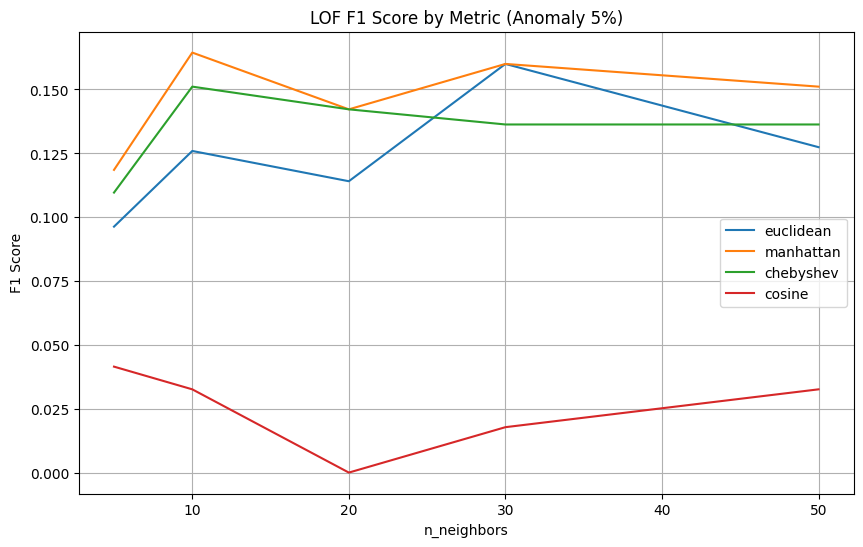

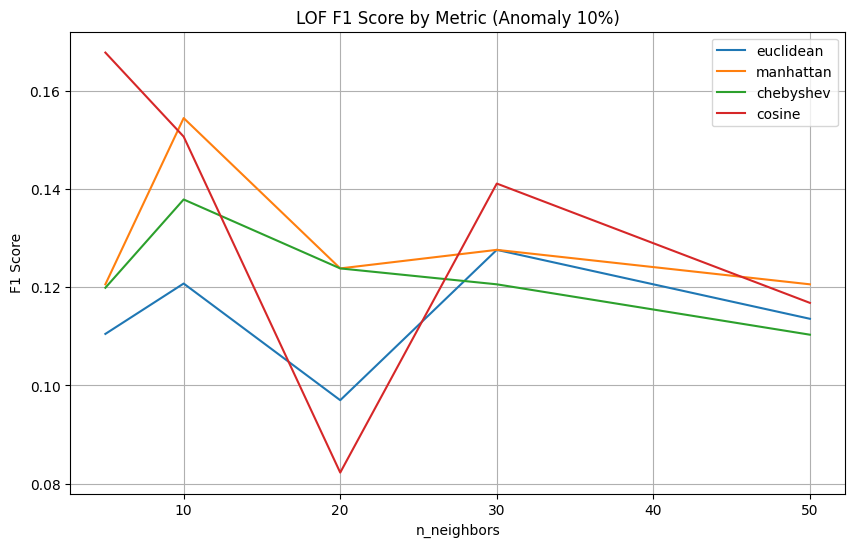

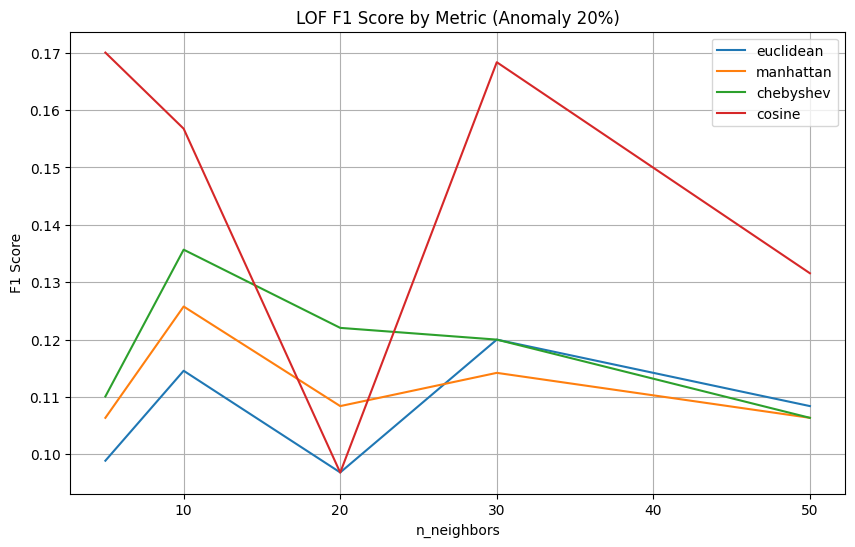

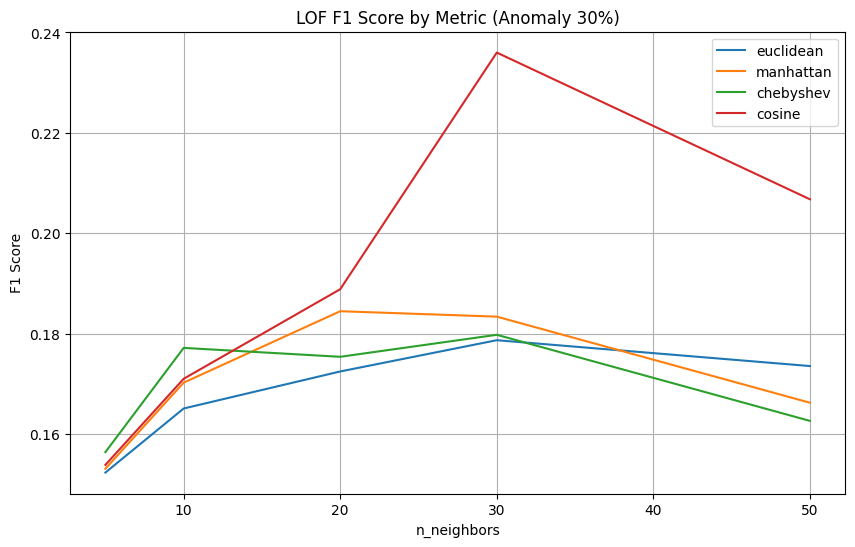

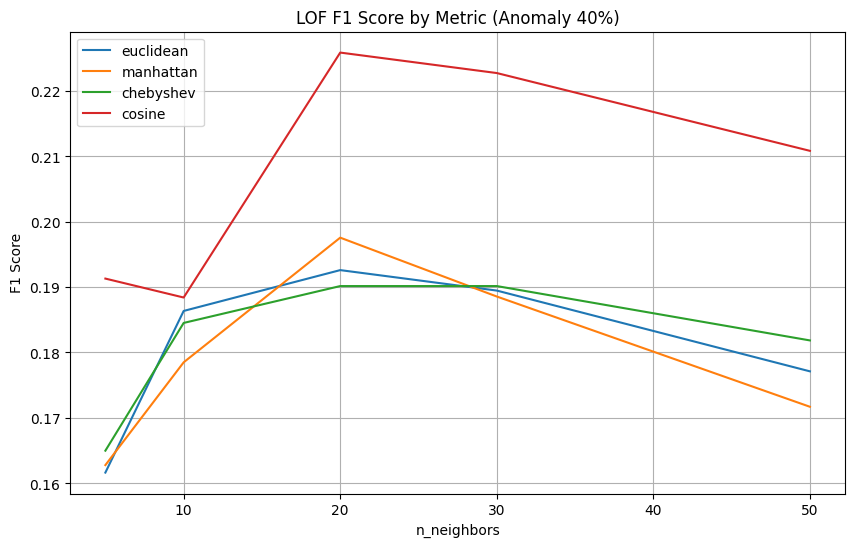

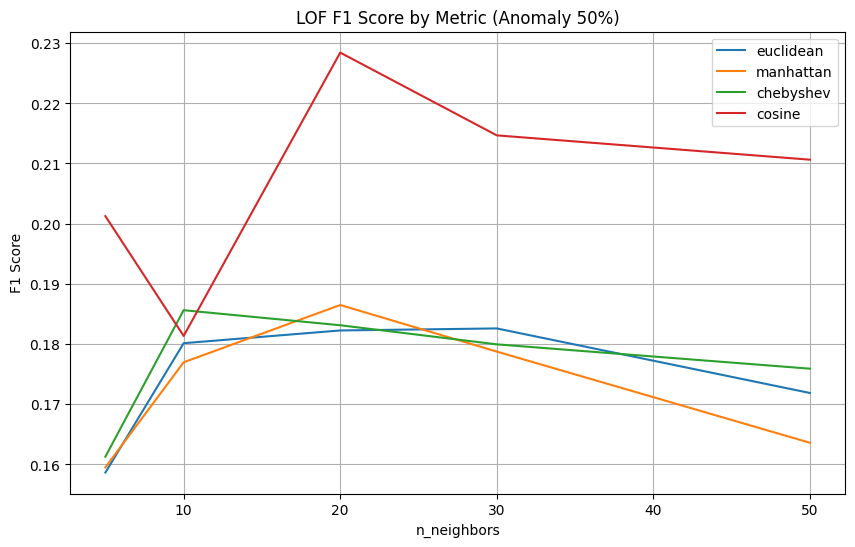

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neighbors import LocalOutlierFactor

# Generate synthetic dataset for demonstration
from sklearn.datasets import make_classification

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic trust score data
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, 
                           n_redundant=1, n_clusters_per_class=1, weights=[0.95], flip_y=0.01)

# Introduce anomalies by flipping some labels
anomaly_percentages = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
lof_results_by_anomaly = {}

for anomaly_percentage in anomaly_percentages:
    # Inject anomalies
    n_anomalies = int(anomaly_percentage * len(y))
    y_with_anomalies = y.copy()
    y_with_anomalies[:n_anomalies] = 1  # Mark as anomalies (label 1)
    y_with_anomalies[n_anomalies:] = 0  # Normal instances

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y_with_anomalies, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    def evaluate_lof_with_metrics(X_train, y_train, X_test, y_test):
        lof_scores = []
        best_lof_score = 0
        best_lof_params = None

        n_neighbors_range = [5, 10, 20, 30, 50]
        contamination_range = [0.05, 0.10, 0.20]
        metric_options = ['euclidean', 'manhattan', 'chebyshev', 'cosine']

        for k in n_neighbors_range:
            for c in contamination_range:
                for m in metric_options:
                    try:
                        lof = LocalOutlierFactor(n_neighbors=k, contamination=c, metric=m)
                        y_pred = lof.fit_predict(X_test)
                        y_pred = np.where(y_pred == -1, 1, 0)
                        f1 = f1_score(y_test, y_pred)
                        lof_scores.append({'n_neighbors': k, 'contamination': c, 'metric': m, 'f1': f1})

                        if f1 > best_lof_score:
                            best_lof_score = f1
                            best_lof_params = {'n_neighbors': k, 'contamination': c, 'metric': m}
                    except Exception as e:
                        print(f"Error with LOF({k}, {c}, {m}): {e}")
                        continue

        return best_lof_params, lof_scores

    best_lof_params, lof_scores = evaluate_lof_with_metrics(X_train, y_train, X_test, y_test)

    # Save the best LOF params and scores for plotting
    lof_results_by_anomaly[anomaly_percentage] = {
        'best_params': best_lof_params,
        'all_scores': lof_scores
    }

# Plotting
for anomaly_percentage in anomaly_percentages:
    lof_scores = lof_results_by_anomaly[anomaly_percentage]['all_scores']
    df = pd.DataFrame(lof_scores)

    plt.figure(figsize=(10, 6))
    for metric in df['metric'].unique():
        subset = df[df['metric'] == metric]
        avg_f1 = subset.groupby('n_neighbors')['f1'].mean()
        plt.plot(avg_f1.index, avg_f1.values, label=metric)

    plt.title(f"LOF F1 Score by Metric (Anomaly {int(anomaly_percentage*100)}%)")
    plt.xlabel("n_neighbors")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()
